# Projected outcomes

This notebook contains the code we used to project outcomes under the 10x5 and 50x1 districting plans using demographic threshold inference model (see section 5 of the report).

In [1]:
import pandas
import numpy
from collections import namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import itertools

## Projection model code

In [2]:
class ElectionSampler:
    cases = None
    threshold = None
    
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        return self.cases[number_over_threshold]

    def sample(self, groups: pandas.Series):
        """
        :param pandas.Series groups: a single row of a DataFrame with the percentages
            of each racial group in a ward.
        """
        outcomes, probabilities = self.decide_case(groups)
        outcome = numpy.random.choice(a=outcomes, p=probabilities)
        groups_from_highest_to_lowest = groups.sort_values(ascending=False).keys()
        full_outcome = itertools.chain(
            outcome,
            itertools.repeat(0, len(groups_from_highest_to_lowest) - len(outcome))
        )
        return pandas.Series(full_outcome, index=groups_from_highest_to_lowest)

class ElectionSamplerWithMajority(ElectionSampler):
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        any_majority = (groups > 0.5).any()
        if any_majority and number_over_threshold in self.cases["majority"]:
            return self.cases["majority"][number_over_threshold]
        else:
            return self.cases["plurality"][number_over_threshold]


In [3]:
Case = namedtuple("Case", ["outcomes", "probabilities"])

In [4]:
class TenByFiveSampler(ElectionSampler):
    cases = {
        1: Case(outcomes=((5,), (4,1)), probabilities=(0.5, 0.5)),
        2: Case(((4, 1), (3, 2), (2, 3), (2, 2, 1), (3, 1, 1)), (0.25, 0.55, 0.1, 0.05, 0.05)),
        3: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.25, 0.25, 0.15, 0.2, 0.15)),
        4: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.2, 0.2, 0.2, 0.2, 0.2))
    }
    threshold = 1/6

class FiftyByOneSampler(ElectionSamplerWithMajority):
    cases = {
        "majority": {
            2: Case(((1,), (0,1)), (0.9, 0.1)),
            3: Case(((1,), (0,1,), (0,0,1)), (0.8, 0.18, 0.02))
        },
        "plurality": {
            1: Case(outcomes=((1,), (0,1)), probabilities=(1, 0)),
            2: Case(((1,), (0,1)), (0.6, 0.4)),
            3: Case(((1,), (0,1), (0,0,1)),(0.45, 0.3, 0.25))
        }
    }
    threshold = 0.25
    
class TenByThreeSampler(ElectionSamplerWithMajority):
    cases = {
        "majority": {
            1: Case(outcomes=((3,), (2,1)), probabilities=(0.9, 0.1)),
            2: Case(((3,), (2,1)), (0.2, 0.8)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.5, 0.3, 0.1)),
            
        },
        "plurality": {
            1: Case(((3,), (2,1)), (0.5, 0.5)),
            2: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.5, 0.3, 0.1)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.05, 0.15, 0.1, 0.7))
        }
    }
    threshold = 0.25

In [5]:
def load_data(filename):
    df = pandas.read_csv(filename)
    data = pandas.DataFrame(
        {
            "step": df["step"],
            "ward": df["ward"],
            "White": df["NH_WHITE"] / df["TOTPOP"],
            "Black": df["NH_BLACK"] / df["TOTPOP"],
            "Hispanic": df["HISP"] / df["TOTPOP"],
            "Asian": df["NH_ASIAN"] / df["TOTPOP"],
        }
    )
    return data

## Generating the projections

In [6]:
def random_sample(data, size, sampler):
    all_plans = {step: data.loc[indices] for step, indices in data.groupby("step").groups.items()}
    groups = ["White", "Black", "Hispanic", "Asian"]
    plan_indices = data["step"].unique()
    
    for plan_index in tqdm(numpy.random.choice(plan_indices, size=size)):
        wards = all_plans[plan_index]
        yield wards[groups].apply(sampler.sample, axis=1).sum()

In [7]:
groups = ["Asian", "Black", "Hispanic", "White"]

In [8]:
data = load_data("../ensembles/ca10/results.csv")

In [9]:
outcomes = pandas.DataFrame.from_records(random_sample(data, 100, TenByFiveSampler()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.21it/s]


In [12]:
outcomes.groupby(groups).size()

Asian  Black  Hispanic  White
0      14     14        22       1
              16        20       1
              17        19       1
              18        18       1
              19        17       2
       15     12        23       1
              13        22       1
              14        21       1
              15        20       1
              16        19       3
              17        18       2
              18        17       2
              19        16       1
              21        14       1
       16     14        20       3
              15        19       2
              16        18       4
              17        17       2
              18        16       2
       17     12        21       1
              13        20       1
              14        19       1
              15        18       1
              16        17       5
              17        16       2
              18        15       1
              19        14       1
       18     12        2

In [11]:
data = load_data("../ensembles/prec50/results.csv")
outcomes_prec50 = pandas.DataFrame.from_records(random_sample(data, 10_000, FiftyByOneSampler()))
outcomes_prec50.to_csv("./projection_50x1.csv")
outcomes_prec50.groupby(groups).size().to_csv("./projection_50x1_counts.csv", header=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:10<00:00, 14.89it/s]


In [17]:
data = load_data("../ensembles/prec10/results.csv")
outcomes_prec10 = pandas.DataFrame.from_records(random_sample(data, 10_000, TenByFiveSampler()))
outcomes_prec10.to_csv("./projection_10x5.csv")
outcomes_prec10.groupby(groups).size().to_csv("./projection_10x5_counts.csv", header=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:20<00:00, 71.31it/s]


In [14]:
data = load_data("../ensembles/ca10/results.csv")
outcomes_ca10_by_5 = pandas.DataFrame.from_records(random_sample(data, 10_000, TenByFiveSampler()))
outcomes_ca10_by_5.to_csv("./projection_10x5_CA.csv")
outcomes_ca10_by_5.groupby(groups).size().to_csv("./projection_10x5_CA_counts.csv", header=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:46<00:00, 60.89it/s]


In [22]:
data = load_data("../ensembles/ca10/results.csv")
outcomes_ca10_by_3 = pandas.DataFrame.from_records(random_sample(data, 10_000, TenByThreeSampler()))
outcomes_ca10_by_3.to_csv("./projection_10x3_CA.csv")
outcomes_ca10_by_3.groupby(groups).size().to_csv("./projection_10x3_CA_counts.csv", header=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:03<00:00, 54.44it/s]


## Plotting the results

Here's an example plot of the projections we just made using the 50x1 ensemble.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDAED04080>,
      dtype=object)

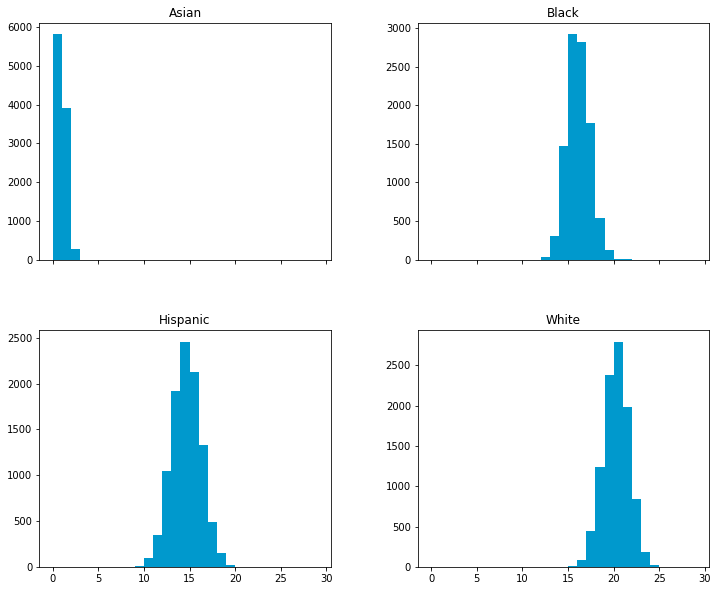

In [13]:

outcomes_prec50[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EDAE4F77B8>,
      dtype=object)

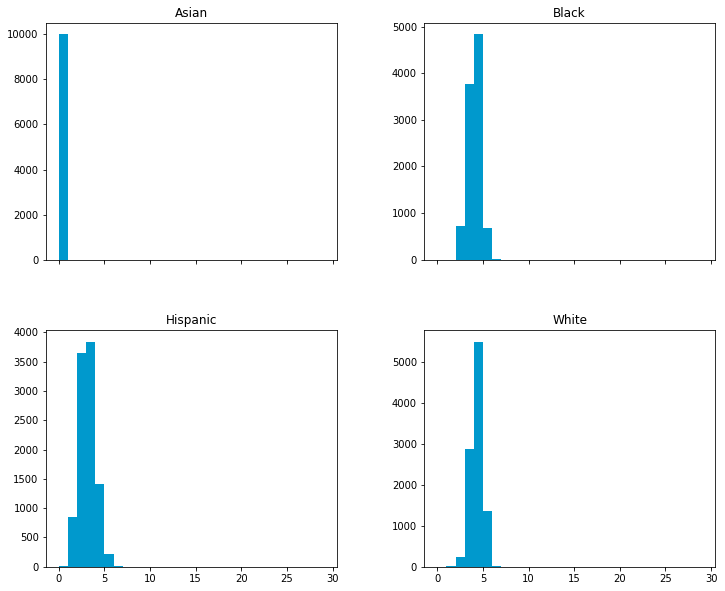

In [16]:
outcomes_prec10_by_5 = pandas.read_csv("./projection_10x5.csv")
outcomes_prec10_by_5[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))

## Statistics

We can use `pandas` to compute statistics for the projected outcomes:

In [ ]:
outcomes_prec50.mean()